# Karras pre-conditioning

https://arxiv.org/abs/2206.00364

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.fid import *

In [ ]:
set_seed(1103, False)
mpl.rcParams['image.cmap'] = 'gray'
logging.disable(logging.WARNING)

In [ ]:
from diffusers import UNet2DModel, DDPMPipeline, DDIMPipeline, DDPMScheduler, DDIMScheduler

In [ ]:
from fastprogress import progress_bar

In [ ]:
fm_x, fm_y = "image", "label"
name = "fashion_mnist"
ds = load_dataset(name)

In [ ]:
@inplace
def transformi2(b):
    b["image"] = [TF.pad(TF.to_tensor(i), padding=2, fill=0, padding_mode="constant") * 2 - 1 for i in b["image"]]
dst2 = ds.with_transform(transformi2)

bs2 = 256
dls2 = DataLoaders.from_dd(dst2, bs2)
xb, yb = next(iter(dls2.train))

fid_model = torch.load('models/14_aug_for_fid.pkl')
del fid_model[8]
del fid_model[7]

image_eval = ImageEval(fid_model, dls2, cbs=[DeviceCB()])
xb.min(), xb.max()

(tensor(-1.), tensor(1.))

In [ ]:
data_std = xb.std()
data_std

tensor(0.6670)

In [ ]:
def scalings(std):
    total_var = (std  ** 2 + data_std ** 2)
    total_std = total_var.sqrt()
    c_skip = data_std ** 2 / total_var
    c_out = std * data_std / total_std
    c_in = 1 / total_std
    return c_skip, c_out, c_in

In [ ]:
sampled_stds = ((torch.randn(1000) * 1.2) - 1.2).exp().clip(0.002, 80)

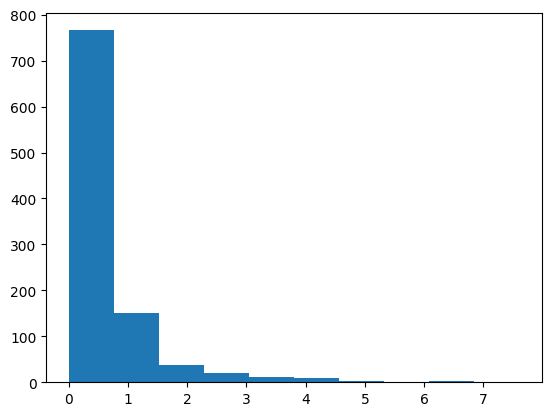

In [ ]:
plt.hist(sampled_stds);

In [ ]:
import seaborn as sns

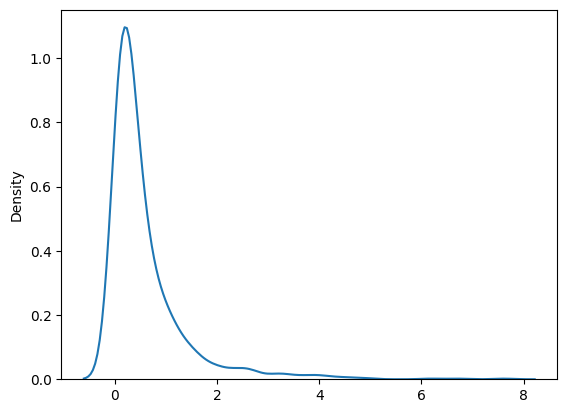

In [ ]:
sns.kdeplot(sampled_stds);

In [ ]:
def add_noise(x0):
    device = x0.device
    bs = x0.shape[0]

    sampled_stds = ((torch.randn((bs,), device=device) * 1.2) - 1.2).exp().clip(0.002, 80).reshape(-1, 1, 1, 1)
    c_skip, c_out, c_in = scalings(sampled_stds)
    
    noise = torch.randn(x0.shape, device=device)
    noise_part = sampled_stds * noise
    xt = x0 + noise_part

    input = c_in * xt
    target = (1 / c_out) * (x0 - c_skip * xt)
    
    return (input, sampled_stds.reshape(-1)), target

In [ ]:
(inp, stds), target = add_noise(xb[:16])

In [ ]:
titles = list(map(lambda x: f"{x:.2f}", stds))

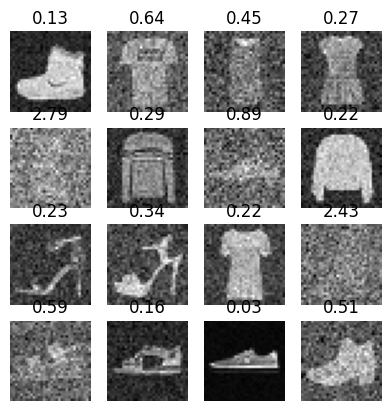

In [ ]:
show_images(inp, imsize=1.2, titles=titles);

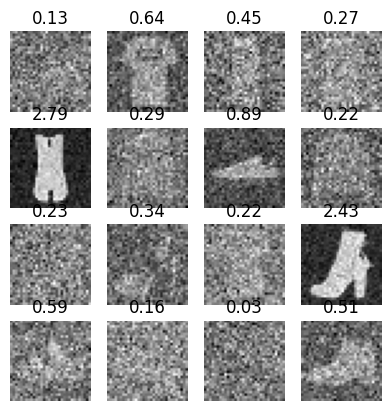

In [ ]:
show_images(target, imsize=1.2, titles=titles);

In [ ]:
def get_collate_ddpm():
    def _collate_ddpm(b):
        return add_noise(default_collate(b)[fm_x])
    return _collate_ddpm

collate_ddpm = get_collate_ddpm()

In [ ]:
def dl_ddpm(ds):
    return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [ ]:
bs = 128
dls = DataLoaders(dl_ddpm(dst2["train"]), dl_ddpm(dst2["test"]))
xb, yb = next(iter(dls.train))

In [ ]:
titles = list(map(lambda x: f"{x:.2f}", xb[1][:16]))

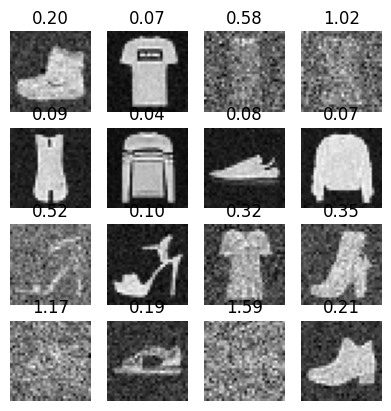

In [ ]:
show_images(xb[0][:16], imsize=1.2, titles=titles);

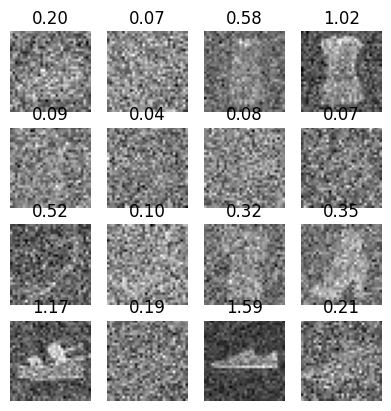

In [ ]:
show_images(yb[:16], imsize=1.2, titles=titles);

In [ ]:
xb[0].mean(), xb[0].std()

(tensor(-0.6891), tensor(1.0155))

In [ ]:
yb.mean(), yb.std()

(tensor(-0.4019), tensor(1.0246))

## Train

In [ ]:
class UNet(UNet2DModel):
    def forward(self, x):
        return super().forward(*x).sample

In [ ]:
def init_ddpm(model):
    for down_block in model.down_blocks:
        for resnet in down_block.resnets:
            resnet.conv2.weight.data.zero_()
        downsamplers = down_block.downsamplers
        if not downsamplers: downsamplers = []
        for downsampler in downsamplers:
            init.orthogonal_(downsampler.conv.weight)

    model.conv_out.weight.data.zero_()

loss,epoch,train
0.595,0,train
0.234,0,valid
0.202,1,train
0.184,1,valid
0.178,2,train
0.172,2,valid
0.166,3,train
0.163,3,valid
0.159,4,train
0.158,4,valid


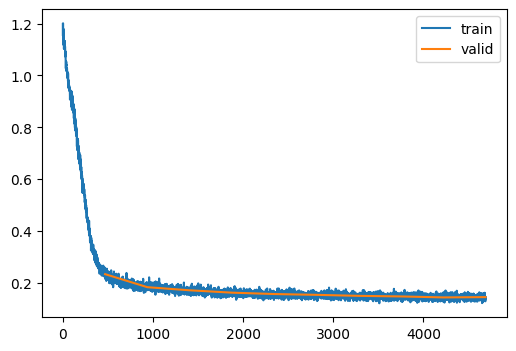

In [ ]:
set_seed(1103, False)
lr = 0.001
epochs = 10
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
cbs = [DeviceCB(), ProgressCB(True), MetricsCB(), sched]

model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=16)
init_ddpm(model)

opt_func = partial(optim.AdamW, eps=1e-4)

learn = TrainLearner(model, dls, F.mse_loss, lr=lr, cbs=cbs, opt_func=opt_func)
learn.fit(epochs)

In [ ]:
model_path = Path("models")
model_path.mkdir(exist_ok=True)
torch.save(learn.model, model_path / "23_karras_10.pkl")

In [ ]:
model_path = Path("models")
model = torch.load(model_path / "23_karras_10.pkl").cuda()

In [ ]:
set_seed(1103, False)

In [ ]:
def denoise(model, x, std):
    # target = (1 / c_out) * (x0 - c_skip * xt)
    # x0 = c_skip * xt + target * c_out
    c_skip, c_out, c_in = scalings(std)
    predicted = model((x * c_in.reshape(-1, 1, 1, 1), std))
    return c_skip.reshape(-1, 1, 1, 1) * x + c_out.reshape(-1, 1, 1, 1) * predicted

In [ ]:
predicted = to_cpu(denoise(model, xb[0][:16].cuda(), xb[1][:16].cuda()))

In [ ]:
predicted.min(), predicted.max()

(tensor(-1.7249), tensor(1.6981))

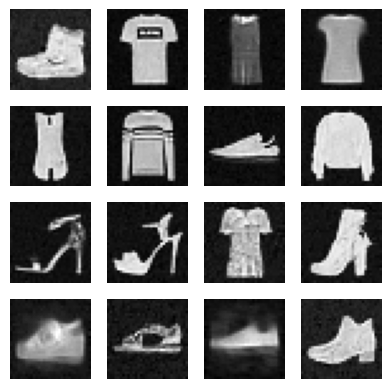

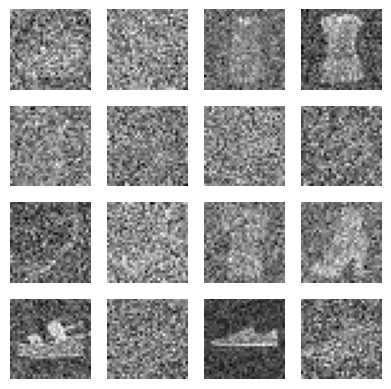

In [ ]:
c = 16
show_images(predicted, imsize=1.2);
show_images(yb[:c], imsize=1.2)

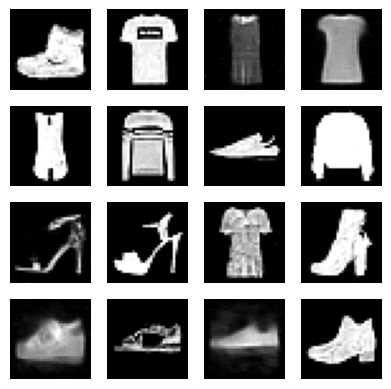

In [ ]:
show_images(predicted.clip(-1, 1), imsize=1.2);

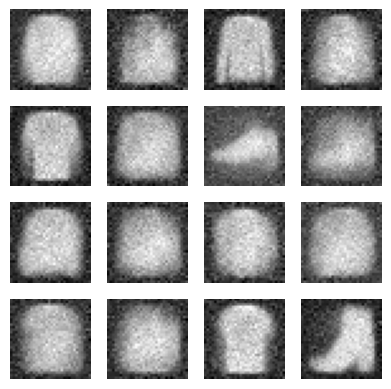

In [ ]:
stds = torch.tensor(80)
x = torch.randn((16, 1, 32, 32)) * stds
predicted = denoise(model, x.cuda(), stds.cuda())
show_images(predicted, imsize=1.2);

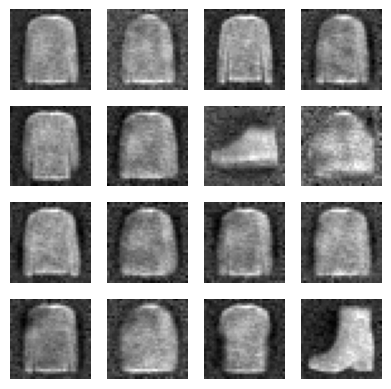

In [ ]:
stds = torch.tensor(30)
predicted = denoise(model, predicted * stds.cuda(), stds.cuda())
show_images(predicted, imsize=1.2);

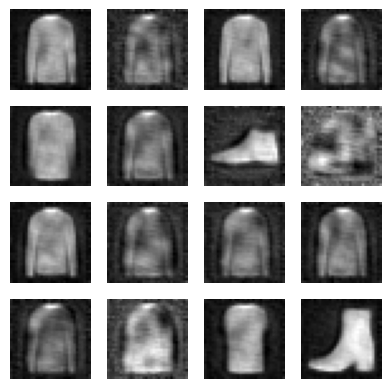

In [ ]:
stds = torch.tensor(10)
predicted = denoise(model, predicted * stds.cuda(), stds.cuda())
show_images(predicted, imsize=1.2);

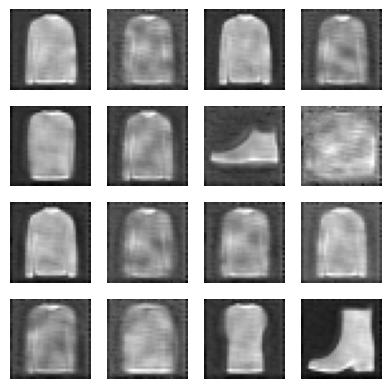

In [ ]:
stds = torch.tensor(1)
x = torch.randn((16, 1, 32, 32))
predicted = to_cpu(denoise(model, predicted * stds.cuda(), stds.cuda()))
show_images(predicted, imsize=1.2);

## Sampling

In [ ]:
def sigmas_karras(n, sigma_min=0.01, sigma_max=80, rho=7, device="cpu"):
    i = torch.linspace(0, 1, n)
    min_scale = sigma_min ** (1 / rho)
    max_scale = sigma_max ** (1 / rho)
    sigmas = (max_scale + i * (min_scale - max_scale)) ** rho
    sigmas = torch.cat((sigmas, tensor([0.]))).to(device=device)
    return sigmas

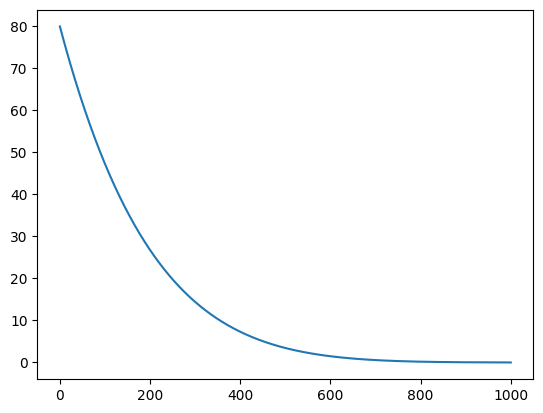

In [ ]:
plt.plot(sigmas_karras(1000));

In [ ]:
def denoise(model, x, std):
    # target = (1 / c_out) * (x0 - c_skip * xt)
    # x0 = c_skip * xt + target * c_out
    c_skip, c_out, c_in = scalings(std)
    predicted = model((x * c_in, std))
    return c_skip * x + c_out * predicted

In [ ]:
def sample_euler(x, sigs, i, model):
    with torch.no_grad():
        sig1, sig2 = sigs[i], sigs[i + 1]
        x0 = denoise(model, x, sig1)
        mult = (sig2 - sig1) / sig1
        # x_prev = x + (x - x0) * mult
        x_prev = x * (1 + mult) - x0 * mult
    return x_prev

In [ ]:
def sample(sampler, model, steps=100, sigma_max=80, shape=(bs2, 1, 32, 32), **kwargs):
    device = model.device
    x = torch.randn(shape, device=device) * sigma_max
    sigmas = sigmas_karras(steps, sigma_max=sigma_max, device=device)
    with torch.no_grad():
        for step in progress_bar(range(len(sigmas) - 1)):
            x = sampler(x, sigmas, step, model, **kwargs)
    return x

In [ ]:
set_seed(1103, False)
samples = sample(sample_euler, model)
samples.min(), samples.max()

(tensor(-1.1571, device='cuda:0'), tensor(1.4284, device='cuda:0'))

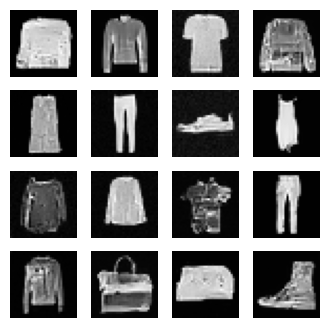

In [ ]:
show_images(samples[:16], imsize=1);

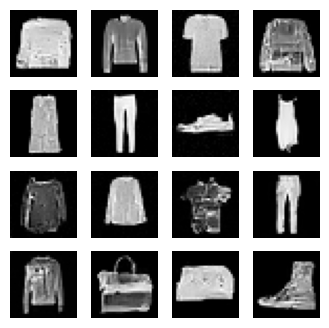

In [ ]:
show_images(samples[:16].clip(-1, 1), imsize=1);

In [ ]:
image_eval.fid(samples), image_eval.kid(samples)

(29.499755859375, 0.07922744750976562)

In [ ]:
samples = samples.clip(-1, 1)
image_eval.fid(samples), image_eval.kid(samples)

(29.2589111328125, 0.07894086837768555)

In [ ]:
xb, yb = next(iter(dls2.train))
image_eval.fid(xb), image_eval.kid(xb)

(15.4024658203125, -0.006153106689453125)